In [1]:
import ee
import geemap
import pandas as pd
from matplotlib import pyplot


#ee.Authenticate()  # Only needed for the first time
ee.Initialize()
Map= geemap.Map()

In [2]:
lake = ee.FeatureCollection('projects/ee-mazard/assets/adk-samplelakes') \
    .filter(ee.Filter.eq('GNIS_Name', 'Avalanche Lake'))

#data = pd.read_csv("C:\\Users\\Touhe\\TimeSeriesGenerationData_excel.csv", index_col=0, parse_dates=True)


In [4]:
station = ee.Geometry.Point(-73.96958229920722,44.13073943656968)
Map.addLayer(station)
Map.centerObject(station, 16)
Map

Map(center=[44.13073943656968, -73.96958229920722], controls=(WidgetControl(options=['position', 'transparent_…

In [5]:
def cdom(img):
    co = img.expression("(20.3 - 10. * (b2 / b3) - 2.4 * (b3 / b4))", {
        'b2': img.select('SR_B2'),
        'b3': img.select('SR_B3'),
        'b4': img.select('SR_B4')
    }).rename("CO")
    return img.addBands([co])


In [6]:
def maskL457sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    qa = image.select('QA_PIXEL')
    cloud = qa.bitwiseAnd(1 << 5).Or(qa.bitwiseAnd(1 << 7)).Or(qa.bitwiseAnd(1 << 3))
    masked = image.updateMask(cloud.Not())
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBand = image.select('ST_B6').multiply(0.00341802).add(-124.15)
    return image.addBands(opticalBands, None, True).addBands(thermalBand, None, True).updateMask(masked).updateMask(qaMask).updateMask(saturationMask)


l5 = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
   .filter(ee.Filter.calendarRange(5, 11, 'month')) \
   .filterBounds(station) \
   .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
   .map(cdom)

l5 = l5.map(maskL457sr)


In [7]:
def maskL8sr(image):
    # Bit 0 - Fill
    # Bit 1 - Dilated Cloud
    # Bit 2 - Cirrus
    # Bit 3 - Cloud
    # Bit 4 - Cloud Shadow
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)

    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(-124.15)

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
        .addBands(thermalBands, None, True) \
        .updateMask(qaMask) \
        .updateMask(saturationMask)

l8 =ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(5, 11, 'month')) \
    .filterBounds(station) \
    .filter(ee.Filter.lt('CLOUD_COVER', 25)) \
    .map(cdom)


l8 = l8.map(maskL8sr)


#merge landsat 5 and landsat 8
lall = ee.ImageCollection(l5.merge(l8));

In [8]:
def station_mean(img):
    mean = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=station, scale=30).get('CO')
    return img.set('date', img.date().format()).set('mean',mean)

In [9]:
station_reduced_imgs = lall.map(station_mean)


In [10]:
nested_list = station_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['date','mean']).values().get(0)

In [11]:
# dont forget we need to call the callback method "getInfo" to retrieve the data
df = pd.DataFrame(nested_list.getInfo(), columns=['date','mean'])

df

,date,mean
0,1984-06-17T15:07:00,8.644180
1,1984-09-21T15:08:47,8.211801
2,1984-10-07T15:08:46,8.189312
3,1984-11-08T15:08:35,8.136106
4,1985-07-22T15:08:33,8.386366
...,...,...
141,2020-10-17T15:45:11,8.293824
142,2021-05-13T15:44:25,8.444483
143,2021-10-20T15:45:17,8.398671
144,2022-11-24T15:45:24,8.287634


In [12]:

df['date'] = pd.to_datetime(df['date'])

# Format 'date' column to exclude the time
df['date'] = df['date'].dt.date
df

,date,mean
0,1984-06-17,8.644180
1,1984-09-21,8.211801
2,1984-10-07,8.189312
3,1984-11-08,8.136106
4,1985-07-22,8.386366
...,...,...
141,2020-10-17,8.293824
142,2021-05-13,8.444483
143,2021-10-20,8.398671
144,2022-11-24,8.287634


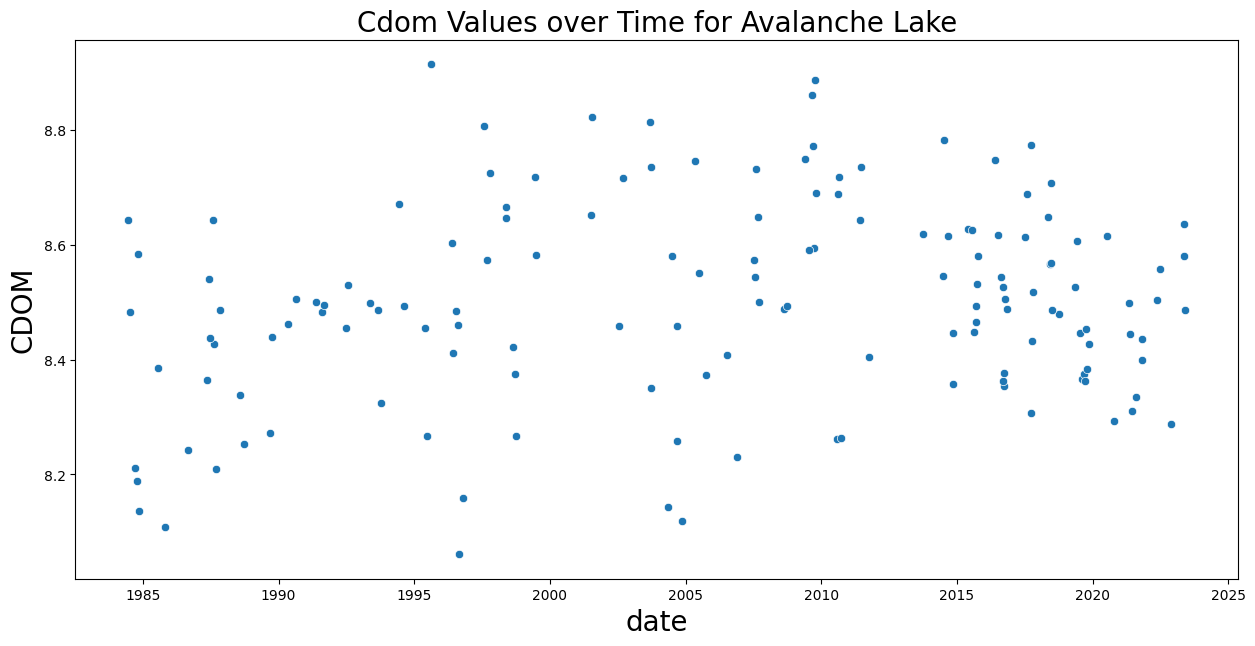

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
# Create a figure with subplots and set the dimensions to 15 x 7
fig, ax = plt.subplots(figsize=(15, 7))

# Create the plot by setting our dataframe to the data argument
sns.scatterplot(data=df, x='date', y='mean', ax=ax)

# Set the labels and title
ax.set_ylabel('CDOM', fontsize=20)
ax.set_xlabel('date', fontsize=20)
ax.set_title('Cdom Values over Time for Avalanche Lake', fontsize=20)

# Format the x-axis tick labels to display only the year
# ax.xaxis.set_major_formatter(plt.FixedFormatter(df['date'].dt.year.unique()))

# Display the plot
plt.show()
